In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [49]:
training_data = pd.read_csv("titanic_train.csv")
test_data = pd.read_csv("titanic_test.csv")

print("The dimension of our training data frame is: ", training_data.shape)
print("The dimension of our training data frame is: ", test_data.shape)

The dimension of our training data frame is:  (891, 12)
The dimension of our training data frame is:  (418, 11)


CHACKING AND HANDLING MISSING VALUES BOTH IN TRAINING & TEST DATA

In [50]:
training_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

IMPUTATING MISSING VALUES IN TRAINING DATA & DROPPING CABIN VARIABLE

In [51]:
# Imputating missing values
training_data["Age"].fillna(training_data["Age"].mean(), inplace=True)
training_data['Embarked'].fillna(training_data['Embarked'].mode()[0], inplace=True)

# Droping Cabin variable
training_data.drop(columns='Cabin', axis=1,inplace=True)
training_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [52]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

IMPUTATING MISSING VALUES IN TEST DATA & DROPPING CABIN VARIABLE

In [53]:
# Imputating missing values
test_data["Age"].fillna(test_data["Age"].mean(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].mean(), inplace=True)

# Droping Cabin variable
test_data.drop(columns='Cabin', axis=1,inplace=True)

test_data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

CORRELATION FOR TRAINING DATA

In [54]:
def corr(data):
    correlation = data.corr()
    sns.heatmap(correlation, annot=True, cbar=True, cmap="RdYlGn")
    
corr(training_data)

CORRELATION FOR TEST DATA

In [55]:
def corr(data):
    correlation = data.corr()
    sns.heatmap(correlation, annot=True, cbar=True, cmap="RdYlGn")
    
corr(test_data)

RECODING OF CATEGORICAL VARIABLES (GENDER AND EMBARKED) BOTH FOR TRAINING AND TEST DATA

In [56]:
training_data.replace({'Sex':{'male':0,'female':1}, 'Embarked':{'S':0,'C':1,'Q':2}}, inplace=True)
test_data.replace({'Sex':{'male':0,'female':1}, 'Embarked':{'S':0,'C':1,'Q':2}}, inplace=True)

In [57]:
training_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

             Ticket     Fare  Embarked  
0         A/5 21171   7.2500         0  
1          PC 17599  71.2833         1  
2  STON/O2. 3101282   7.9250         0  
3            113803  53.1000         0  
4            373450   8.0500         0

In [58]:
test_data.head()

PassengerId  Pclass                                          Name  Sex  \
0          892       3                              Kelly, Mr. James    0   
1          893       3              Wilkes, Mrs. James (Ellen Needs)    1   
2          894       2                     Myles, Mr. Thomas Francis    0   
3          895       3                              Wirz, Mr. Albert    0   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)    1   

    Age  SibSp  Parch   Ticket     Fare  Embarked  
0  34.5      0      0   330911   7.8292         2  
1  47.0      1      0   363272   7.0000         0  
2  62.0      0      0   240276   9.6875         2  
3  27.0      0      0   315154   8.6625         0  
4  22.0      1      1  3101298  12.2875         0

CREATING NEW VARIABLE FARE-BIN FROM FARE & SURVIVED USING TRAINING DATASET

In [59]:
from sklearn.cluster import KMeans
# Use KMeans to cluster fare data
fare_data = training_data[['Fare','Survived']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(training_data[['Fare','Survived']])
Fare_bin = kmeans.labels_


# Create a new variable 'fare bin'
training_data.loc[(training_data['Fare'] == 0), 'Fare-bin'] = 0
training_data.loc[(training_data['Fare'] > 0) & (training_data['Fare'] < 48), 'Fare-bin'] = 1
training_data.loc[(training_data['Fare'] >= 48), 'Fare-bin'] = 2

# Survival rates by fare bins
training_data.groupby(['Fare-bin'])['Survived'].describe()

count      mean       std  min  25%  50%  75%  max
Fare-bin                                                    
0.0        15.0  0.066667  0.258199  0.0  0.0  0.0  0.0  1.0
1.0       712.0  0.323034  0.467964  0.0  0.0  0.0  1.0  1.0
2.0       164.0  0.676829  0.469120  0.0  0.0  1.0  1.0  1.0

CREATING NEW VARIABLE FARE-BIN FOR FARE FOR TEST DATASET USING KMEAN CLUSTERING RESULTS FROM TRAINING DATA

In [60]:

# Create a new variable 'fare bin'
test_data.loc[(test_data['Fare'] == 0), 'Fare-bin'] = 0
test_data.loc[(test_data['Fare'] > 0) & (test_data['Fare'] < 48), 'Fare-bin'] = 1
test_data.loc[(test_data['Fare'] >= 48), 'Fare-bin'] = 2

In [61]:
training_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

             Ticket     Fare  Embarked  Fare-bin  
0         A/5 21171   7.2500         0       1.0  
1          PC 17599  71.2833         1       2.0  
2  STON/O2. 3101282   7.9250         0       1.0  
3            113803  53.1000         0       2.0  
4            373450   8.0500         0       1.0

In [62]:
test_data.head()

PassengerId  Pclass                                          Name  Sex  \
0          892       3                              Kelly, Mr. James    0   
1          893       3              Wilkes, Mrs. James (Ellen Needs)    1   
2          894       2                     Myles, Mr. Thomas Francis    0   
3          895       3                              Wirz, Mr. Albert    0   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)    1   

    Age  SibSp  Parch   Ticket     Fare  Embarked  Fare-bin  
0  34.5      0      0   330911   7.8292         2       1.0  
1  47.0      1      0   363272   7.0000         0       1.0  
2  62.0      0      0   240276   9.6875         2       1.0  
3  27.0      0      0   315154   8.6625         0       1.0  
4  22.0      1      1  3101298  12.2875         0       1.0

MAKING NEW VARIABLE (TITLE) FROM NAME BOTH FOR TRAINING AND TEST DATA

In [63]:
# Get the title from Name
training_data["Title"] = training_data["Name"].apply(lambda x: x[x.find(', ')+2 : x.find('.')])
training_data["Title"].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [64]:
# Get the title from Name
test_data["Title"] = test_data["Name"].apply(lambda x: x[x.find(', ')+2 : x.find('.')])
test_data["Title"].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64

In [65]:
# Create a new variable 'title group'
training_data['Title group'] = 'other'

for t in ['Mr','Miss','Mrs','Master']:
  training_data.loc[training_data['Title'] == t, 'Title group'] = t

# Survival rate by title group
training_data.groupby(['Title group'])['Survived'].describe()

count      mean       std  min  25%  50%  75%  max
Title group                                                    
Master        40.0  0.575000  0.500641  0.0  0.0  1.0  1.0  1.0
Miss         182.0  0.697802  0.460477  0.0  0.0  1.0  1.0  1.0
Mr           517.0  0.156673  0.363844  0.0  0.0  0.0  0.0  1.0
Mrs          125.0  0.792000  0.407510  0.0  1.0  1.0  1.0  1.0
other         27.0  0.444444  0.506370  0.0  0.0  0.0  1.0  1.0

In [66]:
# Create a new variable 'title group'
test_data['Title group'] = 'other'

for t in ['Mr','Miss','Mrs','Master']:
  test_data.loc[test_data['Title'] == t, 'Title group'] = t


CREATING NEW VARIRABLE TRAVEL SIZE USING TICKET BOTH FOR TRAINING AND TEST DATA

In [67]:
# Group passengers by ticket number
same_ticket = training_data.groupby('Ticket')['PassengerId'].nunique().reset_index()
same_ticket.rename(columns={'PassengerId': 'passenger count'}, inplace=True)

# Create a new variable 'travel size'
travel_group_2ppl = same_ticket[same_ticket['passenger count'] == 2]
travel_group_3ppl = same_ticket[same_ticket['passenger count'] == 3]
travel_group_4ppl = same_ticket[same_ticket['passenger count'] == 4]
travel_group_5ppl = same_ticket[same_ticket['passenger count'] >= 5]

training_data['Travel size'] = 'a. alone'
training_data.loc[training_data['Ticket'].isin(travel_group_2ppl['Ticket']), 
             'Travel size'] = 'b. 2 ppl'
training_data.loc[training_data['Ticket'].isin(travel_group_3ppl['Ticket']), 
             'Travel size'] = 'c. 3 ppl'
training_data.loc[training_data['Ticket'].isin(travel_group_4ppl['Ticket']), 
             'Travel size'] = 'd. 4 ppl'
training_data.loc[training_data['Ticket'].isin(travel_group_5ppl['Ticket']), 
             'Travel size'] = 'e. 5+ ppl'

# Survival rate by travel size
training_data.groupby(['Travel size'])['Survived'].describe()


count      mean       std  min  25%  50%  75%  max
Travel size                                                    
a. alone     547.0  0.297989  0.457793  0.0  0.0  0.0  1.0  1.0
b. 2 ppl     188.0  0.574468  0.495744  0.0  0.0  1.0  1.0  1.0
c. 3 ppl      63.0  0.698413  0.462633  0.0  0.0  1.0  1.0  1.0
d. 4 ppl      44.0  0.500000  0.505781  0.0  0.0  0.5  1.0  1.0
e. 5+ ppl     49.0  0.102041  0.305839  0.0  0.0  0.0  0.0  1.0

In [68]:
# Group passengers by ticket number
same_ticket = test_data.groupby('Ticket')['PassengerId'].nunique().reset_index()
same_ticket.rename(columns={'PassengerId': 'passenger count'}, inplace=True)

# Create a new variable 'travel size'
travel_group_2ppl = same_ticket[same_ticket['passenger count'] == 2]
travel_group_3ppl = same_ticket[same_ticket['passenger count'] == 3]
travel_group_4ppl = same_ticket[same_ticket['passenger count'] == 4]
travel_group_5ppl = same_ticket[same_ticket['passenger count'] >= 5]

test_data['Travel size'] = 'a. alone'
test_data.loc[test_data['Ticket'].isin(travel_group_2ppl['Ticket']), 
             'Travel size'] = 'b. 2 ppl'
test_data.loc[test_data['Ticket'].isin(travel_group_3ppl['Ticket']), 
             'Travel size'] = 'c. 3 ppl'
test_data.loc[test_data['Ticket'].isin(travel_group_4ppl['Ticket']), 
             'Travel size'] = 'd. 4 ppl'
test_data.loc[test_data['Ticket'].isin(travel_group_5ppl['Ticket']), 
             'Travel size'] = 'e. 5+ ppl'

In [69]:
training_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

             Ticket     Fare  Embarked  Fare-bin Title Title group Travel size  
0         A/5 21171   7.2500         0       1.0    Mr          Mr    a. alone  
1          PC 17599  71.2833         1       2.0   Mrs         Mrs    a. alone  
2  STON/O2. 3101282   7.9250         0       1.0  Miss        Miss    a. alone  
3            113803  53.1000         0       2.0   Mrs         Mrs    b. 2 ppl  
4            373450   8.0500         0       1.0    Mr          Mr    a. alone

In [70]:
test_data.head()

PassengerId  Pclass                                          Name  Sex  \
0          892       3                              Kelly, Mr. James    0   
1          893       3              Wilkes, Mrs. James (Ellen Needs)    1   
2          894       2                     Myles, Mr. Thomas Francis    0   
3          895       3                              Wirz, Mr. Albert    0   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)    1   

    Age  SibSp  Parch   Ticket     Fare  Embarked  Fare-bin Title Title group  \
0  34.5      0      0   330911   7.8292         2       1.0    Mr          Mr   
1  47.0      1      0   363272   7.0000         0       1.0   Mrs         Mrs   
2  62.0      0      0   240276   9.6875         2       1.0    Mr          Mr   
3  27.0      0      0   315154   8.6625         0       1.0    Mr          Mr   
4  22.0      1      1  3101298  12.2875         0       1.0   Mrs         Mrs   

  Travel size  
0    a. alone  
1    a. alone  
2    a. alone  
3    a. alone  
4    a. alone

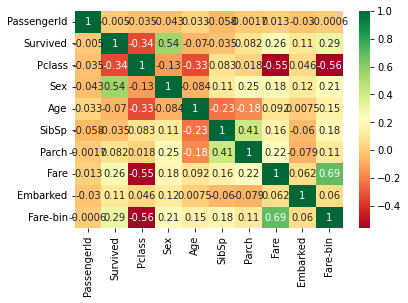

In [71]:
def corr(data):
    correlation = data.corr()
    sns.heatmap(correlation, annot=True, cbar=True, cmap="RdYlGn")
    
corr(training_data)

since fare and fare-bin have strong negative correlation with Pclass so both variables are dropped from training & test datasets

In [72]:
training_data.drop(columns=['PassengerId','Name', 'Ticket', 'Title', 'Fare', 'Fare-bin'] , axis=1,inplace=True)
test_data.drop(columns=['PassengerId','Name', 'Ticket', 'Title', 'Fare', 'Fare-bin'] , axis=1,inplace=True)

In [73]:
training_data.head()

Survived  Pclass  Sex   Age  SibSp  Parch  Embarked Title group Travel size
0         0       3    0  22.0      1      0         0          Mr    a. alone
1         1       1    1  38.0      1      0         1         Mrs    a. alone
2         1       3    1  26.0      0      0         0        Miss    a. alone
3         1       1    1  35.0      1      0         0         Mrs    b. 2 ppl
4         0       3    0  35.0      0      0         0          Mr    a. alone

In [74]:
test_data.head()

Pclass  Sex   Age  SibSp  Parch  Embarked Title group Travel size
0       3    0  34.5      0      0         2          Mr    a. alone
1       3    1  47.0      1      0         0         Mrs    a. alone
2       2    0  62.0      0      0         2          Mr    a. alone
3       3    0  27.0      0      0         0          Mr    a. alone
4       3    1  22.0      1      1         0         Mrs    a. alone

In [75]:
training_data_dummies = pd.get_dummies(training_data)
training_data_dummies.head()

Survived  Pclass  Sex   Age  SibSp  Parch  Embarked  Title group_Master  \
0         0       3    0  22.0      1      0         0                   0   
1         1       1    1  38.0      1      0         1                   0   
2         1       3    1  26.0      0      0         0                   0   
3         1       1    1  35.0      1      0         0                   0   
4         0       3    0  35.0      0      0         0                   0   

   Title group_Miss  Title group_Mr  Title group_Mrs  Title group_other  \
0                 0               1                0                  0   
1                 0               0                1                  0   
2                 1               0                0                  0   
3                 0               0                1                  0   
4                 0               1                0                  0   

   Travel size_a. alone  Travel size_b. 2 ppl  Travel size_c. 3 ppl  \
0                     1                     0                     0   
1                     1                     0                     0   
2                     1                     0                     0   
3                     0                     1                     0   
4                     1                     0                     0   

   Travel size_d. 4 ppl  Travel size_e. 5+ ppl  
0                     0                      0  
1                     0                      0  
2                     0                      0  
3                     0                      0  
4                     0                      0

In [76]:
test_data_dummies = pd.get_dummies(test_data)
test_data_dummies.head()

Pclass  Sex   Age  SibSp  Parch  Embarked  Title group_Master  \
0       3    0  34.5      0      0         2                   0   
1       3    1  47.0      1      0         0                   0   
2       2    0  62.0      0      0         2                   0   
3       3    0  27.0      0      0         0                   0   
4       3    1  22.0      1      1         0                   0   

   Title group_Miss  Title group_Mr  Title group_Mrs  Title group_other  \
0                 0               1                0                  0   
1                 0               0                1                  0   
2                 0               1                0                  0   
3                 0               1                0                  0   
4                 0               0                1                  0   

   Travel size_a. alone  Travel size_b. 2 ppl  Travel size_c. 3 ppl  \
0                     1                     0                     0   
1                     1                     0                     0   
2                     1                     0                     0   
3                     1                     0                     0   
4                     1                     0                     0   

   Travel size_d. 4 ppl  Travel size_e. 5+ ppl  
0                     0                      0  
1                     0                      0  
2                     0                      0  
3                     0                      0  
4                     0                      0

PREPARING DATA FOR MODELLING

In [77]:
X_train = training_data_dummies.drop(columns = ['Survived'],axis=1)
X_train

Pclass  Sex        Age  SibSp  Parch  Embarked  Title group_Master  \
0         3    0  22.000000      1      0         0                   0   
1         1    1  38.000000      1      0         1                   0   
2         3    1  26.000000      0      0         0                   0   
3         1    1  35.000000      1      0         0                   0   
4         3    0  35.000000      0      0         0                   0   
..      ...  ...        ...    ...    ...       ...                 ...   
886       2    0  27.000000      0      0         0                   0   
887       1    1  19.000000      0      0         0                   0   
888       3    1  29.699118      1      2         0                   0   
889       1    0  26.000000      0      0         1                   0   
890       3    0  32.000000      0      0         2                   0   

     Title group_Miss  Title group_Mr  Title group_Mrs  Title group_other  \
0                   0               1                0                  0   
1                   0               0                1                  0   
2                   1               0                0                  0   
3                   0               0                1                  0   
4                   0               1                0                  0   
..                ...             ...              ...                ...   
886                 0               0                0                  1   
887                 1               0                0                  0   
888                 1               0                0                  0   
889                 0               1                0                  0   
890                 0               1                0                  0   

     Travel size_a. alone  Travel size_b. 2 ppl  Travel size_c. 3 ppl  \
0                       1                     0                     0   
1                       1                     0                     0   
2                       1                     0                     0   
3                       0                     1                     0   
4                       1                     0                     0   
..                    ...                   ...                   ...   
886                     1                     0                     0   
887                     1                     0                     0   
888                     0                     1                     0   
889                     1                     0                     0   
890                     1                     0                     0   

     Travel size_d. 4 ppl  Travel size_e. 5+ ppl  
0                       0                      0  
1                       0                      0  
2                       0                      0  
3                       0                      0  
4                       0                      0  
..                    ...                    ...  
886                     0                      0  
887                     0                      0  
888                     0                      0  
889                     0                      0  
890                     0                      0  

[891 rows x 16 columns]

In [78]:
Y_train = training_data_dummies['Survived']
Y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [79]:
X_test = test_data_dummies
X_test

Pclass  Sex       Age  SibSp  Parch  Embarked  Title group_Master  \
0         3    0  34.50000      0      0         2                   0   
1         3    1  47.00000      1      0         0                   0   
2         2    0  62.00000      0      0         2                   0   
3         3    0  27.00000      0      0         0                   0   
4         3    1  22.00000      1      1         0                   0   
..      ...  ...       ...    ...    ...       ...                 ...   
413       3    0  30.27259      0      0         0                   0   
414       1    1  39.00000      0      0         1                   0   
415       3    0  38.50000      0      0         0                   0   
416       3    0  30.27259      0      0         0                   0   
417       3    0  30.27259      1      1         1                   1   

     Title group_Miss  Title group_Mr  Title group_Mrs  Title group_other  \
0                   0               1                0                  0   
1                   0               0                1                  0   
2                   0               1                0                  0   
3                   0               1                0                  0   
4                   0               0                1                  0   
..                ...             ...              ...                ...   
413                 0               1                0                  0   
414                 0               0                0                  1   
415                 0               1                0                  0   
416                 0               1                0                  0   
417                 0               0                0                  0   

     Travel size_a. alone  Travel size_b. 2 ppl  Travel size_c. 3 ppl  \
0                       1                     0                     0   
1                       1                     0                     0   
2                       1                     0                     0   
3                       1                     0                     0   
4                       1                     0                     0   
..                    ...                   ...                   ...   
413                     1                     0                     0   
414                     1                     0                     0   
415                     1                     0                     0   
416                     1                     0                     0   
417                     1                     0                     0   

     Travel size_d. 4 ppl  Travel size_e. 5+ ppl  
0                       0                      0  
1                       0                      0  
2                       0                      0  
3                       0                      0  
4                       0                      0  
..                    ...                    ...  
413                     0                      0  
414                     0                      0  
415                     0                      0  
416                     0                      0  
417                     0                      0  

[418 rows x 16 columns]

RUNNING DECISION TREES, SVM AND LOGISTIC MODEL ON TRAINING DATA

In [82]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

decision_tree = DecisionTreeClassifier()
scores_decision_trees = cross_val_score(decision_tree, X_train, Y_train, cv=10)
acc_decision_tree = scores_decision_trees.mean()

svc = SVC()
scores_svc = cross_val_score(svc, X_train, Y_train, cv=10)
acc_svc = scores_svc.mean()

lr = LogisticRegression(max_iter=1000)
scores_lr = cross_val_score(lr, X_train, Y_train, cv=10)
acc_lr = scores_lr.mean()



# Overview
models = pd.DataFrame({
    'Model': ['Decision Tree', 'Support Vector Machines', 'Logistic Regression'],
    'Score': [acc_decision_tree, acc_svc, acc_lr]})
models.sort_values(by='Score', ascending=False)

Model     Score
2      Logistic Regression  0.823820
0            Decision Tree  0.775605
1  Support Vector Machines  0.654357

PREDICTING SURVIVED VARIABLE FOR TEST DATA

In [81]:
# Predicting Survived Varialbe for Test Data
log_reg = LogisticRegression(solver = "liblinear")
log_reg.fit(X_train, Y_train)
Y_test_lr = log_reg.predict(X_test)
lr_scores = cross_val_score(log_reg, X_test, Y_test_lr, cv = 10)
test_lr = lr_scores.mean()

dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)
Y_test_dt = dt.predict(X_test)
dt_scores = cross_val_score(dt, X_test, Y_test_dt, cv=10)
test_decision_tree = dt_scores.mean()

sv = SVC()
sv.fit(X_train, Y_train)
Y_test_sv = sv.predict(X_test)
sv_scores = cross_val_score(sv, X_test, Y_test_sv, cv=10)
test_sv = sv_scores.mean()

# Overview
test_models = pd.DataFrame({
    'Test Model': ['Decision Tree', 'Support Vector Machines', 'Logistic Regression'],
    'Test_Score': [test_decision_tree, test_sv, test_lr]})
test_models.sort_values(by='Test_Score', ascending=False)




Test Model  Test_Score
2      Logistic Regression    0.985482
1  Support Vector Machines    0.944890
0            Decision Tree    0.882811